In [3]:
import boto3
from fastcore.basics import store_attr
from fastcore.xtras import Path
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize, ColSplitter, RandomSplitter
from fastai.losses import FocalLossFlat
from fastai.losses import DiceLoss
from fastai.torch_core import tensor
from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats, SegmentationDataLoaders
from fastai.vision.learner import unet_learner
import numpy as np
from torchvision.models.resnet import resnet34
import torch
import torch.nn.functional as F
import boto3
import shutil
from fastai.learner import save_model
%matplotlib inline
from PIL import ImageDraw
import json
from skimage import measure
from shapely.geometry import shape, Point, Polygon, LineString
from pathlib import Path
from PIL import Image
from numpy import asarray
import numpy as np
from typing import List, Tuple
from typing_extensions import Literal
from pyproj import Proj
from pyproj import transform as pyproj_transform
import requests
from fastai.learner import load_learner
from fastai.vision.learner import unet_learner, load_model
import shutil
from torchvision.models.resnet import resnet34
import PIL
import cv2
import geopandas
from matplotlib import pyplot as plt

In [4]:
# Bypasses missing class issues when doing predictions
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.,gamma=3):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis,gamma=gamma)
        self.dice_loss =  DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

def label_func(x:Path):
    pass


def get_geomatrix_from_geotif(geotif_file:Path) -> dict:
    img = Image.open(geotif_file)
    # I was kind of interested in how geotiffs actually store their extra data
    #33922 = {tuple: 6} (0.0, 0.0, 0.0, -90.09961019702047, 29.970205197509287, 0.0)
    #33550 = {tuple: 3} (8.023776338680176e-06, 8.023776338680176e-06, 0.0)
    # https://www.awaresystems.be/imaging/tiff/tifftags/modelpixelscaletag.html
    # https://www.awaresystems.be/imaging/tiff/tifftags/modeltiepointtag.html
    # these two tags give me enough info to go from image space to world space (EPSG:4326)
    return dict(
        x_offset=img.tag[33922][3],
        x_multiplier = img.tag[33550][0],
        y_offset = img.tag[33922][4],
        y_multiplier = img.tag[33550][1]
    )

def coord_convert(geo_matrix, x, y,ratio:float):
        #note: Because I downscale the images, I'll need to add this multiplication back.
        # I always get my northings and eastings order confused, so x and y are flipped
        # gdal spec is that the Y direction needs to be a negative, becomes pretty obvious when you plot it.
        if geo_matrix['y_multiplier'] > 0:
            geo_matrix['y_multiplier'] = -geo_matrix['y_multiplier']
        return (geo_matrix['x_offset'] + geo_matrix['x_multiplier']*y* (1/ratio) ), geo_matrix['y_offset'] + geo_matrix['y_multiplier'] * x * (1/ratio)


def pix_poly_to_latlon_pol(geo_matrix: List[float], poly: Polygon,ratio:float) -> Polygon:
    #

    lon_list = []
    lat_list = []
    x, y = poly.exterior.coords.xy
    for x_val, y_val in zip(x, y):
        lon, lat = coord_convert(geo_matrix, x_val, y_val,ratio)
        lat_list.append(lat)  # lat and lon are right here but not sure of order in poly. TODO
        lon_list.append(lon)
    return Polygon([[ln, la] for la, ln in zip(lat_list, lon_list)])  # todo did I cook lat lons order like I usually do
    #return Polygon([EPSG_3_to_EPSG_4(lat=la,lon=ln,in_proj=Proj('epsg:3857'),out_proj=Proj('epsg:4326')) for la, ln in zip(lat_list, lon_list)])


def get_single_mask(poly:Polygon,after_image,image_index:int,dest_dir:Path,image_name:str) -> Path:
    dump_name = dest_dir / f"{image_name}_{image_index}.jpg"
    x,y  = poly.exterior.coords.xy
    contours = np.array([[round(y),round(x)] for x,y in zip(x,y)])
    mask = np.zeros(after_image.shape,dtype=np.uint8)
    cv2.fillPoly(mask,pts=[contours],color=(255,255,255))
    masked_image = cv2.bitwise_and(after_image,mask)
    cv2.imwrite(dump_name.__str__(),masked_image)
    return dump_name

def mask_2_poly(result:np.array,min_poly_area=20*20) -> List[Polygon]:
    return_list = []
    # Note Mask assumption is 3 = interior, so scrub anything that isn't that.
    arr = np.where(result == 3, 255, 0)
    for found_obj in measure.find_contours(arr, 1.0):
        try:
            poly = Polygon(found_obj).simplify(1)
            if poly.is_valid and poly.area > min_poly_area:
                return_list.append(poly)
        except ValueError:
            # it's possible for the simplified poly to be... weird
            # ValueError: A LinearRing must have at least 3 coordinate tuples
            pass
    return return_list

def list_of_polys_to_geojson(polys: List[Polygon]) -> dict:
    poly_geojson = geopandas.GeoSeries(polys).__geo_interface__
    # Add in EPSG3857 coordinates

    return poly_geojson





In [5]:
# Load models:
# Note: The assumption here is that you have run the previous two stages to get the two required models
# Please see https://github.com/SrzStephen/DisaVu/tree/main/nbs
model_1_path = Path().resolve() / "predict_footprint_fine_tuned"
model_2_path = Path().resolve() / "predict_damage_unfrozen"
predict_footprint = load_learner(model_1_path)
predict_damage = load_learner(model_2_path)

In [6]:
# The datasets here are tiled versions of geotiffs from https://www.maxar.com/open-data
# The data is released under https://creativecommons.org/licenses/by-nc-sa/4.0/
# And also general note: Good on them for releasing post disaster satellite imagery
# that's so well cropped and specific as a public good.

def download_file(file_url:str,to_file:Path) -> None:
    # Too much indentation for my brain to follow
    print("Downloading file")
    with requests.get(url=file_url,stream=True) as req:
        req.raise_for_status()
        with open(to_file,'wb') as fp:
            for chunk in req.iter_content(chunk_size=2**12):
                fp.write(chunk)
                

In [7]:
file_url = 'https://stephenbucketsagemaker.s3.amazonaws.com/inference_data.zip'
tmp_dir = Path("/tmp/")
file_nam = tmp_dir / "stage3.zip"
unzip_dir = tmp_dir /   "data_for_stage3"
if not file_nam.exists():
    download_file(file_url=file_url,to_file = file_nam)



In [8]:
if not unzip_dir.exists():
    unzip_dir.mkdir()
shutil.unpack_archive(filename=file_nam,
                      extract_dir=unzip_dir,
                      format='zip')

In [14]:
before_dir = unzip_dir / "before"
after_dir = unzip_dir / "after"
after_masked = unzip_dir / "after_masked"

# File format is FILENAME_LAT_lon.tif
# The before/after images are going to have a different FILENAME

one_file_in_before = [x for x in before_dir.glob("*.tif")][2]
before_filename = one_file_in_before.name.split("_")[0]

one_file_in_after = next(after_dir.glob("*.tif"))
after_filename = one_file_in_after.name.split("_")[0]

one_file_in_after = str(after_dir/ one_file_in_before.name).replace(before_filename,after_filename)

print(one_file_in_after)
print(one_file_in_before)

/tmp/data_for_stage3/after/10300100C540A500_-90.125_30.432.tif
/tmp/data_for_stage3/before/105001001E0A3300_-90.125_30.432.tif


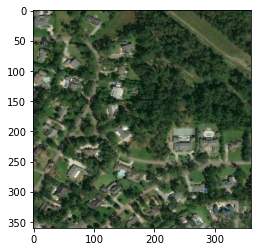

In [15]:
plt.imshow(np.array(Image.open(one_file_in_after)))

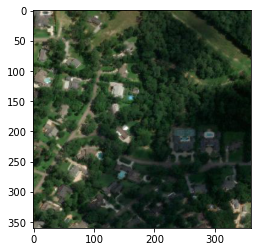

In [16]:
plt.imshow(np.array(Image.open(one_file_in_before)))

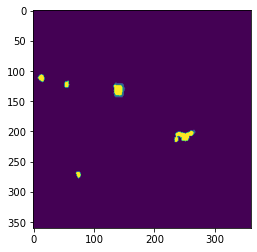

In [17]:
# What we've noticed is that due to a combination of just being trained on the vegas set and the decreased resolution, the building model fails to pick up a lot more buildings
plt.imshow(predict_footprint.predict(one_file_in_before)[0])

In [18]:
bad_polys:List[Polygon] = []
good_polys:List[Polygon] = []

if not after_masked.exists():
    after_masked.mkdir(parents=True)
file_count = 0
for file in before_dir.glob('*.tif'):
    file_count+=1
    
    img_original = np.array(Image.open(file))

    after_image_dir = before_dir / file.name
    geom = get_geomatrix_from_geotif(file)
    result = predict_footprint.predict(item=file)[0]
    pixel_ratio_to_original = result.shape[0]/img_original.shape[0]
    # the predicted footprints are a series of polygons that we'll need to cut of out the original image
    for index, poly in enumerate(mask_2_poly(result)):
        # Pull the respective file
        after_image_dir = after_dir / file.name.replace(before_filename,after_filename)
        after_img = cv2.imread(after_image_dir.__str__())
        after_img = cv2.resize(after_img,result.shape)
        mask_path = get_single_mask(poly,after_img,index,dest_dir=after_masked,image_name=file.stem)
        latlon_poly = pix_poly_to_latlon_pol(geom,poly,ratio=pixel_ratio_to_original)
        damage_value:Literal['damaged','undamaged'] = predict_damage.predict(mask_path)[0]
        if damage_value == 'damaged':
            bad_polys.append(latlon_poly)
        elif damage_value == 'undamaged':
            good_polys.append(latlon_poly)
        else:
            raise ValueError(f"I was not expecting this, labels from the buidling detection are stuffed, got {damage_value} expected one of undamaged or damaged")

with open("good.json",'w') as fp:
    json.dump(list_of_polys_to_geojson(good_polys),fp)
with open("bad.json",'w') as fp:
    json.dump(list_of_polys_to_geojson(bad_polys),fp)

In [ ]:
# The good and bad json files can then be loaded into the application to have the inferences available offline.